**Imports** 🕵️‍♂️

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from scipy.signal import detrend
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score

**Functions** 🤌

In [44]:
def check_data_balance(y):
    counter = Counter(y)
    for label, count in counter.items():
        percentage = (count / len(y)) * 100
        print(f"Class {label}: {count} samples ({percentage:.2f}%)")

def preprocess_data(features_to_drop):
    # Load the data
    df = pd.read_csv('../../../data/kc/btc/heiken_ashi/with_trade_indicators/raw/kc_btc_15min_ha_ti.csv')

    # Convert color to 0 for 'red' and 1 for 'green'
    df['color'] = df['color'].map({'red': 0, 'green': 1})

    # Add 'color_change' column: 1 if color changes from the previous row, 0 otherwise
    df['color_change'] = df['color'].diff().abs()

    # Fill the first row's 'color_change' with 0
    df['color_change'].fillna(0, inplace=True)

    # Drop 'time' and 'turnover' columns
    df = df.drop(['time'], axis=1)

    # Drop features
    df = df.drop(features_to_drop, axis=1)

    # Fill NaNs in specific columns with 0
    if 'PSARl_0.01_0.1' in df.columns:
        df['PSARl_0.01_0.1'] = df['PSARl_0.01_0.1'].fillna(0)
    if 'PSARs_0.01_0.1' in df.columns:
        df['PSARs_0.01_0.1'] = df['PSARs_0.01_0.1'].fillna(0)

    # Identify the first non-null row
    first_valid_index = df.dropna().index[0]

    # Drop the rows before this index in both features and target data
    df = df.loc[first_valid_index:]
    target = df['color_change'].loc[first_valid_index:]

    # Use ffill to fill any remaining missing values
    df.ffill(inplace=True)

    # Separate features and target
    features_df = df.drop('color_change', axis=1)

    # Determine the split point
    split_point = int(len(features_df) * 0.8)

    # Split the data into train and test sets
    X_train_df, X_test_df = features_df[:split_point], features_df[split_point:]
    y_train, y_test = target[:split_point], target[split_point:]

    # Initialize a scaler
    scaler = MinMaxScaler()

    # Scale the data
    X_train = scaler.fit_transform(X_train_df)
    X_test = scaler.transform(X_test_df)

    # Keep the column names for later use
    feature_names = X_train_df.columns.tolist()

    # Reshape the data for LSTM and base models
    X_train_lstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test_lstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # For the base model, we don't need to reshape
    X_train_base = X_train
    X_test_base = X_test

    return X_train_lstm, X_test_lstm, y_train, y_test



**Globals** 🌎

In [45]:
# # Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

feature_names = [
    # Fundamental price data
    'open', 'high', 'low', 'close', 

    # Auxiliary data
    'turnover', 'color',

    # Volume-related
    'volume', 'avg_vol_last_100', 'obv', 

    # Momentum and trend indicators
    'RSI_5', 'RSI_10', 'RSI_14',
    'MACD_12_26_9', 'MACDh_12_26_9', 'MACDs_12_26_9', 'MACD_6_13_5_6_13_5', 'MACDh_6_13_5_6_13_5', 'MACDs_6_13_5_6_13_5', 

    # Moving averages
    'SMA_20', 'SMA_5', 'SMA_10', 'EMA_2', 'EMA_5', 'EMA_10', 

    # Bollinger Bands
    'BBP_10_2.0_10', 'BBL_15_2.0_15', 'BBM_15_2.0_15', 'BBU_15_2.0_15', 'BBB_15_2.0_15', 'BBP_15_2.0_15', 'BBL_20_2.0_20', 'BBM_20_2.0_20', 'BBU_20_2.0_20', 'BBB_20_2.0_20', 'BBP_20_2.0_20', 'bollinger_bandwidth',
    'BBL_5_2.0_5', 'BBM_5_2.0_5', 'BBU_5_2.0_5', 'BBB_5_2.0_5', 'BBP_5_2.0_5', 'BBL_10_2.0_10', 'BBM_10_2.0_10', 'BBU_10_2.0_10', 'BBB_10_2.0_10', 'BBP_10_2.0_10',

    # Stochastic Oscillator
    'STOCHd_14_3_3', 'STOCHk_14_3_3_7_3_3', 'STOCHd_14_3_3_7_3_3', 'STOCHk_14_3_3_10_3_3', 'STOCHd_14_3_3_10_3_3', 

    # Volatility
    'ATR_14', 'ATR_10', 'ATR_5', 

    # Other momentum oscillators
    'ROC_14', 'ROC_10', 'ROC_5', 

    # Other versatile indicators
    'CCI_14', 'CCI_10', 'CCI_5', 

    # Money Flow Index and Chaikin Money Flow
    'cmf', 'mfi',
    
    # Relative Vigor Index (RVI)
    'RVI_15', 'RVI_10', 'RVI_5',
    
    # Pivot Points
    'PP', 'R1', 'S1', 'R2', 'S2', 'R3', 'S3',

    # Parabolic SAR (PSAR)
    'PSARl_0.01_0.1', 'PSARs_0.01_0.1',
    'PSARaf_0.01_0.1', 'PSARr_0.01_0.1',

    # Triple Exponential Average (TRIX)
    'TRIX_18_9', 'TRIXs_18_9', 'TRIX_12_6', 'TRIXs_12_6', 'TRIX_10_5', 'TRIXs_10_5',

    # Ichimoku Cloud (ISA, ISB, ITS, IKS, ICS)
    'ISA_5', 'ISB_15', 'ITS_5', 'IKS_15', 'ICS_15',

]

**Feature Engineering** 🚂

**LSTM Model** 🛰️

In [46]:
# Call your function to preprocess the data
X_train_lstm, X_test_lstm, y_train, y_test = preprocess_data()

# Initialize the model
lstm_model = Sequential()
lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=72, 
                         validation_data=(X_test_lstm, y_test), verbose=2, shuffle=False)

# Predict class labels for the test set
y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")




Epoch 1/10
90/90 - 1s - loss: 0.6911 - accuracy: 0.5438 - val_loss: 0.6879 - val_accuracy: 0.5592 - 1s/epoch - 15ms/step
Epoch 2/10
90/90 - 0s - loss: 0.6861 - accuracy: 0.5560 - val_loss: 0.6876 - val_accuracy: 0.5517 - 130ms/epoch - 1ms/step
Epoch 3/10
90/90 - 0s - loss: 0.6760 - accuracy: 0.5996 - val_loss: 0.6995 - val_accuracy: 0.4651 - 125ms/epoch - 1ms/step
Epoch 4/10
90/90 - 0s - loss: 0.6555 - accuracy: 0.6448 - val_loss: 0.7052 - val_accuracy: 0.4994 - 142ms/epoch - 2ms/step
Epoch 5/10
90/90 - 0s - loss: 0.6276 - accuracy: 0.6766 - val_loss: 0.6995 - val_accuracy: 0.5517 - 127ms/epoch - 1ms/step
Epoch 6/10
90/90 - 0s - loss: 0.6002 - accuracy: 0.6989 - val_loss: 0.6829 - val_accuracy: 0.6091 - 135ms/epoch - 1ms/step
Epoch 7/10
90/90 - 0s - loss: 0.5761 - accuracy: 0.7148 - val_loss: 0.6583 - val_accuracy: 0.6646 - 128ms/epoch - 1ms/step
Epoch 8/10
90/90 - 0s - loss: 0.5560 - accuracy: 0.7296 - val_loss: 0.6310 - val_accuracy: 0.6970 - 130ms/epoch - 1ms/step
Epoch 9/10
90/90 -

**Cross Validation** 🏴‍☠️

**Feature Importance** ✈️

In [47]:
# Call your function to preprocess the data
X_train_base, X_test_base, y_train, y_test, feature_names = preprocess_data()

# Train a random forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
rfc.fit(X_train_base, y_train)

# Get feature importances
importances = rfc.feature_importances_

# Create a dataframe of features and their importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort the dataframe by importance
feature_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the dataframe
print(feature_importances_df)


ValueError: All arrays must be of the same length

Epoch 1/10
90/90 - 1s - loss: 0.6914 - accuracy: 0.5349 - val_loss: 0.6896 - val_accuracy: 0.5455 - 1s/epoch - 14ms/step
Epoch 2/10
90/90 - 0s - loss: 0.6871 - accuracy: 0.5507 - val_loss: 0.6947 - val_accuracy: 0.4875 - 133ms/epoch - 1ms/step
Epoch 3/10
90/90 - 0s - loss: 0.6793 - accuracy: 0.5775 - val_loss: 0.7171 - val_accuracy: 0.4601 - 127ms/epoch - 1ms/step
Epoch 4/10
90/90 - 0s - loss: 0.6635 - accuracy: 0.6197 - val_loss: 0.7278 - val_accuracy: 0.4695 - 138ms/epoch - 2ms/step
Epoch 5/10
90/90 - 0s - loss: 0.6413 - accuracy: 0.6534 - val_loss: 0.7404 - val_accuracy: 0.4981 - 140ms/epoch - 2ms/step
Epoch 6/10
90/90 - 0s - loss: 0.6173 - accuracy: 0.6827 - val_loss: 0.7419 - val_accuracy: 0.5281 - 133ms/epoch - 1ms/step
Epoch 7/10
90/90 - 0s - loss: 0.5945 - accuracy: 0.6987 - val_loss: 0.7278 - val_accuracy: 0.5704 - 129ms/epoch - 1ms/step
Epoch 8/10
90/90 - 0s - loss: 0.5744 - accuracy: 0.7145 - val_loss: 0.7015 - val_accuracy: 0.6203 - 136ms/epoch - 2ms/step
Epoch 9/10
90/90 -

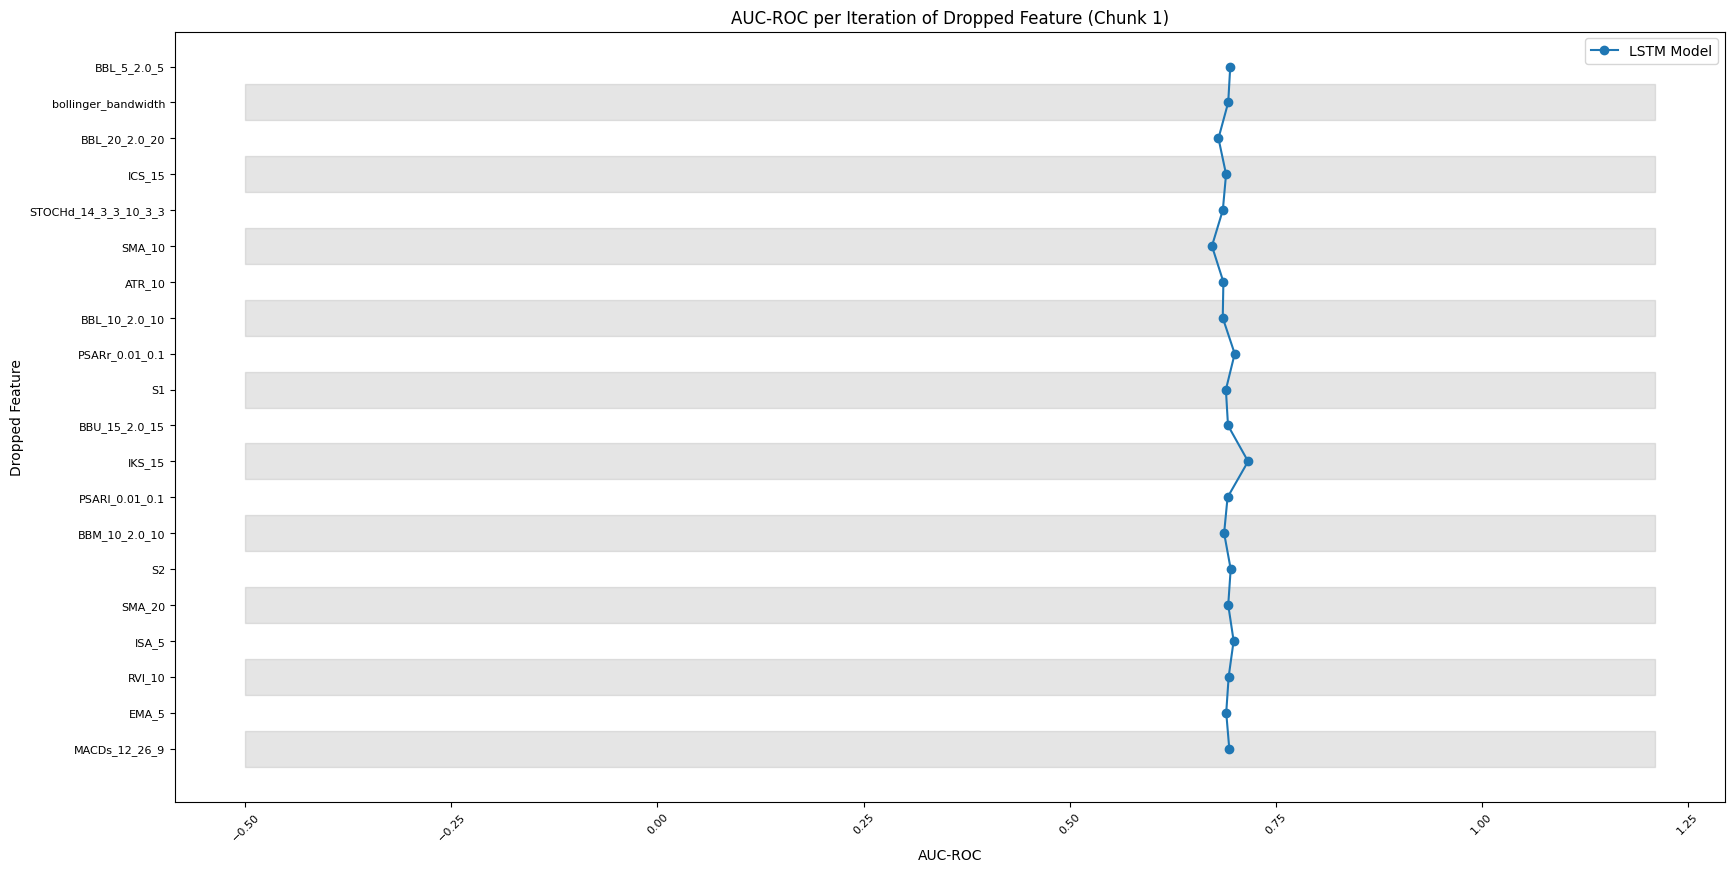

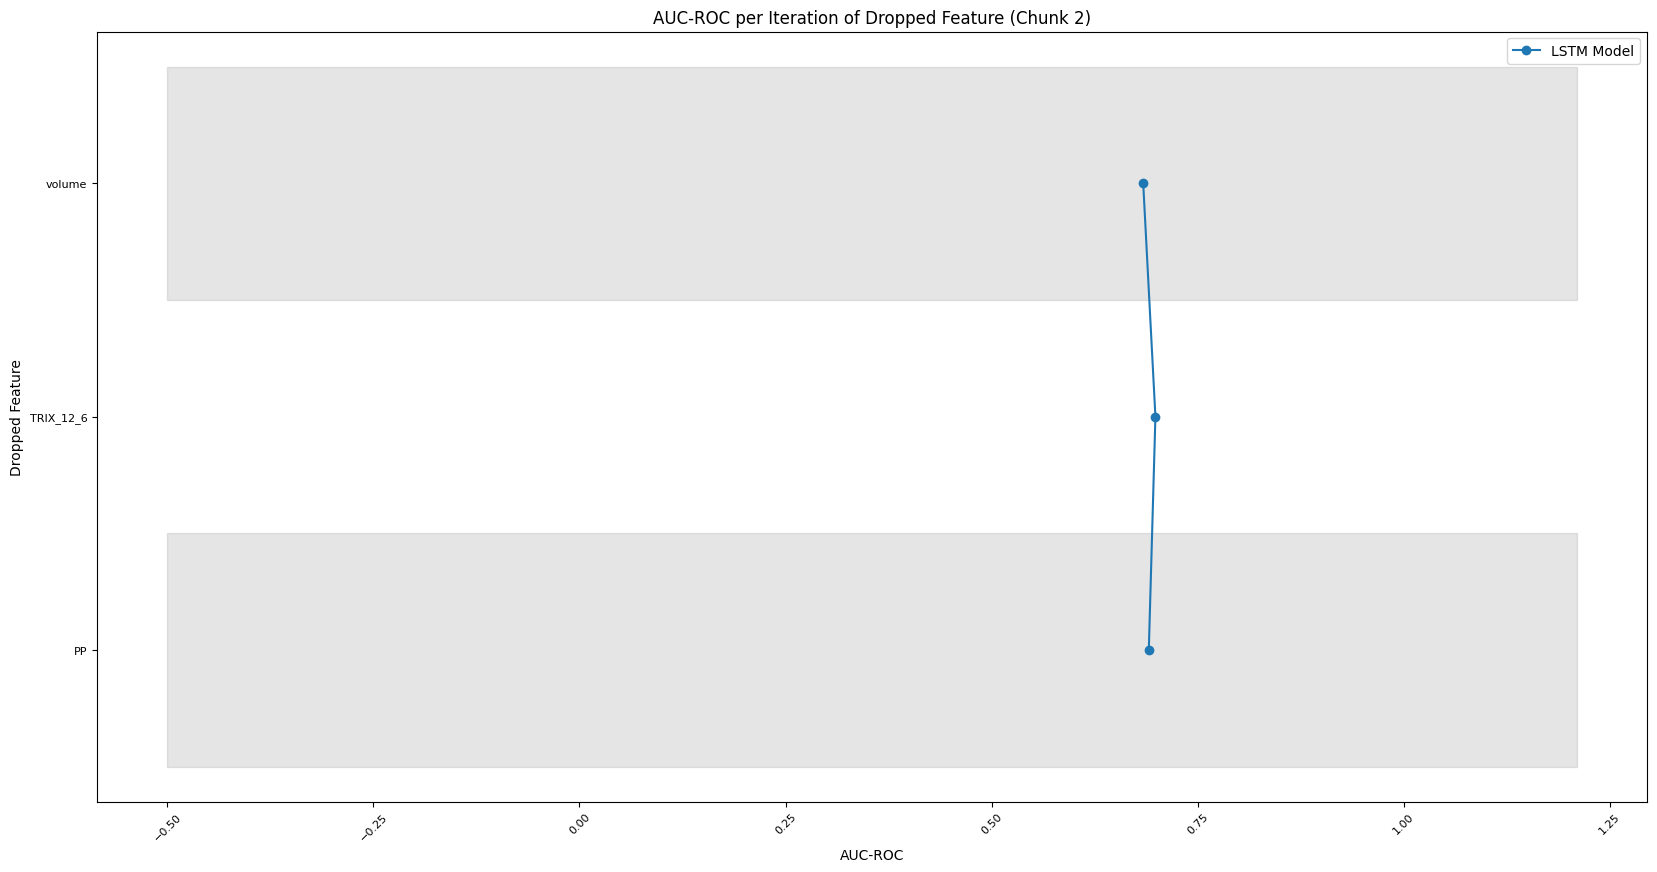

Feature: IKS_15, AUC-ROC score: 0.7167
Feature: PSARr_0.01_0.1, AUC-ROC score: 0.7005
Feature: ISA_5, AUC-ROC score: 0.6992
Feature: TRIX_12_6, AUC-ROC score: 0.6989
Feature: S2, AUC-ROC score: 0.6956
Feature: BBL_5_2.0_5, AUC-ROC score: 0.6951
Feature: MACDs_12_26_9, AUC-ROC score: 0.6939
Feature: RVI_10, AUC-ROC score: 0.6931
Feature: SMA_20, AUC-ROC score: 0.6926
Feature: bollinger_bandwidth, AUC-ROC score: 0.6926
Feature: BBU_15_2.0_15, AUC-ROC score: 0.6923
Feature: PSARl_0.01_0.1, AUC-ROC score: 0.6918
Feature: PP, AUC-ROC score: 0.6909
Feature: EMA_5, AUC-ROC score: 0.6902
Feature: ICS_15, AUC-ROC score: 0.6900
Feature: S1, AUC-ROC score: 0.6898
Feature: BBM_10_2.0_10, AUC-ROC score: 0.6876
Feature: ATR_10, AUC-ROC score: 0.6867
Feature: STOCHd_14_3_3_10_3_3, AUC-ROC score: 0.6861
Feature: BBL_10_2.0_10, AUC-ROC score: 0.6860
Feature: volume, AUC-ROC score: 0.6841
Feature: BBL_20_2.0_20, AUC-ROC score: 0.6808
Feature: SMA_10, AUC-ROC score: 0.6728


In [48]:
# Create a list of the features to be dropped
features_to_drop = ['MACDs_12_26_9', 'EMA_5', 'RVI_10', 'ISA_5', 'SMA_20', 'S2', 'BBM_10_2.0_10', 
                    'PSARl_0.01_0.1', 'IKS_15', 'BBU_15_2.0_15', 'S1', 'PSARr_0.01_0.1', 'BBL_10_2.0_10',
                    'ATR_10', 'SMA_10', 'STOCHd_14_3_3_10_3_3', 'ICS_15', 'BBL_20_2.0_20', 'bollinger_bandwidth',
                    'BBL_5_2.0_5', 'PP', 'TRIX_12_6', 'volume']

# Initialize a list to hold AUC-ROC scores for each iteration
auc_roc_lstm_history = []

for feature in features_to_drop:
    # Call your function to preprocess the data
    X_train_lstm, X_test_lstm, y_train, y_test = preprocess_data([feature])

    # Initialize the LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
    lstm_model.add(Dense(1, activation='sigmoid'))

    # Compile the LSTM model
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Fit the LSTM model
    history = lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=72, 
                             validation_data=(X_test_lstm, y_test), verbose=2, shuffle=False)

    # Predict class labels for the test set
    y_pred_lstm = (lstm_model.predict(X_test_lstm) > 0.5).astype("int32")

    # Compute AUC-ROC for the LSTM model
    auc_roc_lstm = roc_auc_score(y_test, y_pred_lstm)

    # Add the AUC-ROC score to the list
    auc_roc_lstm_history.append(auc_roc_lstm)

# Function to divide the features_to_drop list into sublists of 20 features each
def divide_chunks(lst, chunk_size):
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

# Divide the features_to_drop list into sublists of 20 features each
chunk_size = 20
features_to_drop_chunks = list(divide_chunks(features_to_drop, chunk_size))

# Loop through the sublists and create a chart for each sublist
for chunk_index, features_to_drop_chunk in enumerate(features_to_drop_chunks):

    # Set the figure size
    plt.figure(figsize=(20, 10))

    # Plot the AUC-ROC for each iteration
    plt.plot(auc_roc_lstm_history[chunk_index * chunk_size:(chunk_index + 1) * chunk_size], 
             features_to_drop_chunk, marker='o', label='LSTM Model')

    # Set the axes labels and title
    plt.ylabel('Dropped Feature')
    plt.xlabel('AUC-ROC')
    plt.title(f'AUC-ROC per Iteration of Dropped Feature (Chunk {chunk_index + 1})')

    # Set the x-axis ticks and labels
    plt.xticks(fontsize=8, rotation=45)

    # Set the y-axis ticks and labels
    plt.yticks(range(len(features_to_drop_chunk)), features_to_drop_chunk, fontsize=8)

    # Add colored rows for better readability
    for i in range(len(features_to_drop_chunk)):
        if i % 2 == 0:
            plt.fill_between(np.arange(-0.5, max(auc_roc_lstm_history) + 0.5, 0.01), 
                             i - 0.5, i + 0.5, color='gray', alpha=0.2)

    # Add the legend and display the chart
    plt.legend()
    plt.show()

# Create a dictionary of features and their corresponding AUC-ROC scores
features_auc_roc_lstm_dict = dict(zip(features_to_drop, auc_roc_lstm_history))

# Create a sorted list of tuples from the dictionary
sorted_features_auc_roc_lstm = sorted(features_auc_roc_lstm_dict.items(), key=lambda item: item[1], reverse=True)

# Print the sorted list
for feature, auc_roc in sorted_features_auc_roc_lstm:
    print(f'Feature: {feature}, AUC-ROC score: {auc_roc:.4f}')
